# LSTM modelling for time-series prediction


In [1]:
## Install dependencies
!pip install pandas numpy matplotlib tensorflow tensorflow-gpu

In [5]:
## Importing dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf

In [6]:
## matplotlib parameters
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [7]:
## file loading
directory= os.getcwd()
file= os.listdir(os.path.join(directory, 'src', 'datasets'))
csv_path= os.path.join(directory, 'src', 'datasets', file[0])
df = pd.read_csv(csv_path)

In [8]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [9]:
## 훈련을 위한 파라미터 설정
TRAIN_SPLIT = 300000
BATCH_SIZE = 256
BUFFER_SIZE = 10000
## 학습 시 파라미터
EVALUATION_INTERVAL = 200
EPOCHS = 10

In [10]:
# 재현성을 보장하기 위해 시드 설정.
tf.random.set_seed(13)

In [11]:
## if your PC is equipped with GPU device,tensorflow gpu activation
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus= tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

## Multi-variate LSTM modelling setting

### 다변량(Multivariate LSTM) 데이터란?
입력값의 차원이 2 이상인 경우를 다변량이라고 합니다.
단변량과 다르게, 여러 변수 데이터를 기반으로 미래를 예측하는 경우입니다.

In [14]:
## time-series prediction of multi-variate value
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)'] ## T(대기 온도), p(대기압), rho(공기밀도)
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


In [16]:
## data arrangement
multi_data = features.values
multi_data

array([[ 996.52,   -8.02, 1307.75],
       [ 996.57,   -8.41, 1309.8 ],
       [ 996.53,   -8.51, 1310.24],
       ...,
       [ 999.82,   -3.16, 1288.39],
       [ 999.81,   -4.23, 1293.56],
       [ 999.82,   -4.82, 1296.38]])

## 표준화(Standardization)
통계학에서는 z score가 있습니다.
데이터를 표준정규분포로 정렬하기 위해 계산하는 과정인데요.
표준화는 z score와 동일한 개념으로 이해할 수 있습니다.
표준화 계산은 (데이터 - 평균 / 표준편차)입니다.
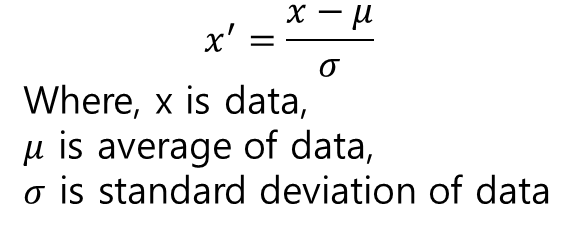
여기서 표준화 계산을 위한 평균, 표준편차 계산은 학습을 위한 데이터셋(train)의 평균, 표준편차 값이어야 합니다.

In [17]:
## data standardization
data_mean = multi_data[:TRAIN_SPLIT].mean(axis=0)
data_std = multi_data[:TRAIN_SPLIT].std(axis=0)
multi_data = (multi_data-data_mean)/data_std

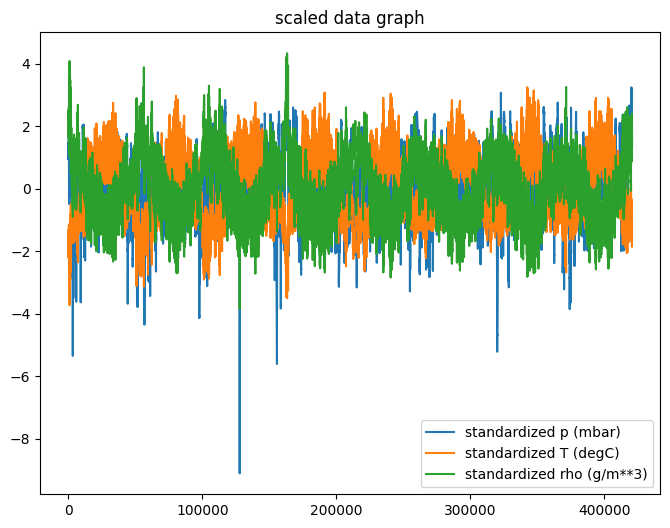

In [20]:
plt.plot(np.arange(multi_data.shape[0]), np.transpose(multi_data)[0], label='standardized p (mbar)')
plt.plot(np.arange(multi_data.shape[0]), np.transpose(multi_data)[1], label='standardized T (degC)')
plt.plot(np.arange(multi_data.shape[0]), np.transpose(multi_data)[2], label='standardized rho (g/m**3)')
plt.title('scaled data graph')
plt.legend()
plt.show()

## 입력 데이터셋 구축하기(Dataset setting)
다변량 모델링 학습을 위한 데이터셋 구축해보도록 하겠습니다.

In [26]:
## dataset: Input dataset
## target: output dataset(target for prediction)
## data_window : data window의 크기 입니다 (하나의 데이터 윈도우에 몇 개의 데이터가 들어가는지)
## target_size : 예측해야하는 레이블 입니다.

def multivariate_data(dataset, target, start_index, end_index, data_window,
                      target_size, step, single_step=False):
  data,labels = [], []

  start_index = start_index + data_window
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-data_window, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

## 여기서 잠깐!
다변량 데이터를 준비할 때, 'STEP'이라는 파라미터를 설정해줍니다.
여기서 STEP 파라미터는, 학습 시 입력되는 데이터 윈도우가 길 경우,
이를 모두 학습하는 것은 많은 비용과 시간이 소모됩니다.
또한 과대적합(Overfitting)의 위험 또한 발생할 수 있고요.
이를 방지하기 위해 데이터 윈도우 중에서도 특정 구간의 데이터만 학습하도록 추출하는 것입니다.

In [30]:
data_window = 720
future_target = 72
STEP = 6

x_train, y_train = multivariate_data(multi_data, multi_data[:, 1], 0,
                                                   TRAIN_SPLIT, data_window,
                                                   future_target, STEP,
                                                   single_step=True)
x_val, y_val = multivariate_data(multi_data, multi_data[:, 1],
                                               TRAIN_SPLIT, None, data_window,
                                               future_target, STEP,
                                               single_step=True)

In [31]:
print(x_train.shape) # Input dimension= (120, 3)
## input data window 길이가 720인데도, 120으로 길이가 줄은 것은 720/6(STEP)이기 때문입니다.
print(y_train.shape) # Input dimension= (1)

(299280, 120, 3)
(299280,)


## 데이터를 텐서 형태로 바꿔줍니다!

In [36]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(BATCH_SIZE).repeat()

## 고대하던 모델링!

In [38]:
## sequence of model
multi_single_model = tf.keras.models.Sequential()
multi_single_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train.shape[-2:]))
multi_single_model.add(tf.keras.layers.Dense(1))

## model compile
multi_single_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae', metrics='mse')

## model fitting
history = multi_single_model.fit(train_data, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 25s 116ms/step - loss: 0.3220 - mse: 0.1957 - val_loss: 0.2552 - val_mse: 0.1066
Epoch 2/10
200/200 [==============================] - 22s 108ms/step - loss: 0.2625 - mse: 0.1159 - val_loss: 0.2461 - val_mse: 0.0999
Epoch 3/10
200/200 [==============================] - 23s 115ms/step - loss: 0.2608 - mse: 0.1137 - val_loss: 0.2472 - val_mse: 0.1014
Epoch 4/10
200/200 [==============================] - 24s 121ms/step - loss: 0.2581 - mse: 0.1112 - val_loss: 0.2367 - val_mse: 0.0931
Epoch 5/10
200/200 [==============================] - 23s 117ms/step - loss: 0.2261 - mse: 0.0886 - val_loss: 0.2286 - val_mse: 0.0851
Epoch 6/10
200/200 [==============================] - 24s 120ms/step - loss: 0.2402 - mse: 0.0969 - val_loss: 0.2607 - val_mse: 0.1081
Epoch 7/10
200/200 [==============================] - 24s 121ms/step - loss: 0.2414 - mse: 0.0993 - val_loss: 0.2509 - val_mse: 0.1038
Epoch 8/10
200/200 [==============================] - 2

In [43]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

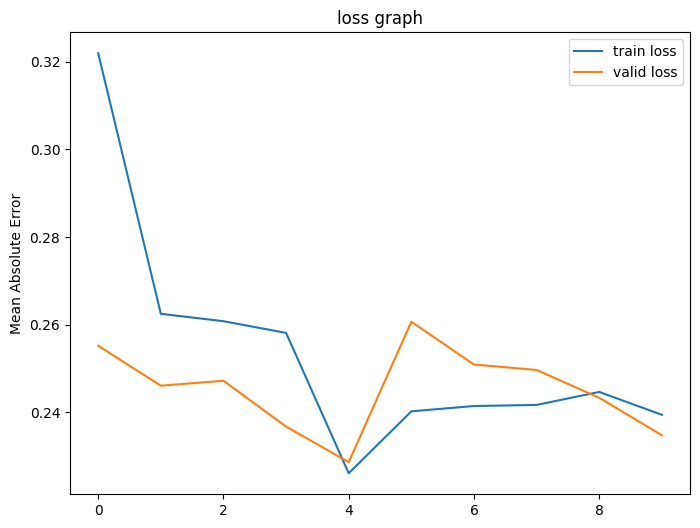

In [44]:
plt.plot(np.arange(len(history.history['loss'])),history.history['loss'], label='train loss')
plt.plot(np.arange(len(history.history['val_loss'])),history.history['val_loss'], label='valid loss')
plt.legend()
plt.ylabel('Mean Absolute Error')
plt.title('loss graph')
plt.show()

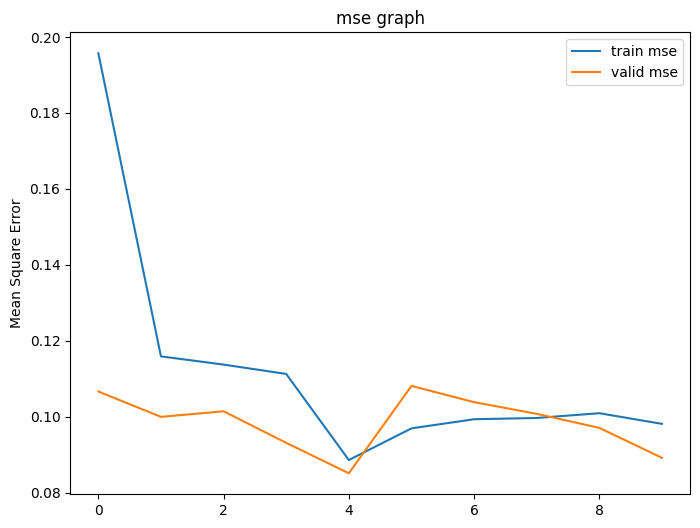

In [45]:
plt.plot(np.arange(len(history.history['mse'])),history.history['mse'], label='train mse')
plt.plot(np.arange(len(history.history['val_mse'])),history.history['val_mse'], label='valid mse')
plt.legend()
plt.ylabel('Mean Square Error')
plt.title('mse graph')
plt.show()

## Inference

In [47]:
def create_time_steps(length):
    return list(range(-length, 0))

In [48]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  plt.show()
  return plt


8/8 [==============================] - 1s 14ms/step


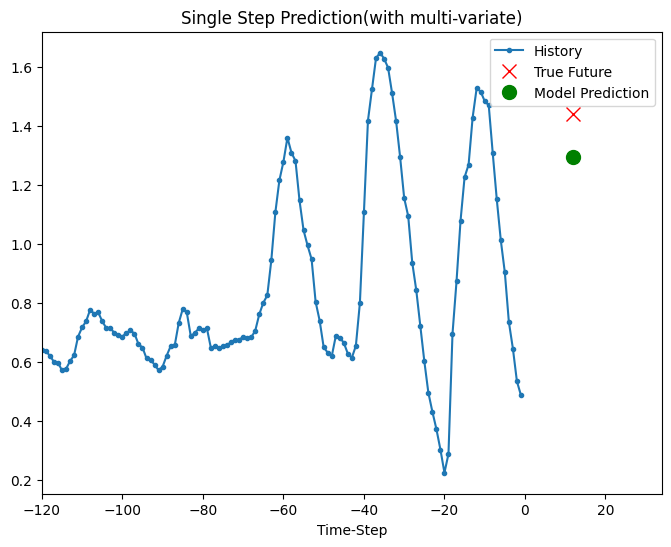

8/8 [==============================] - 0s 14ms/step


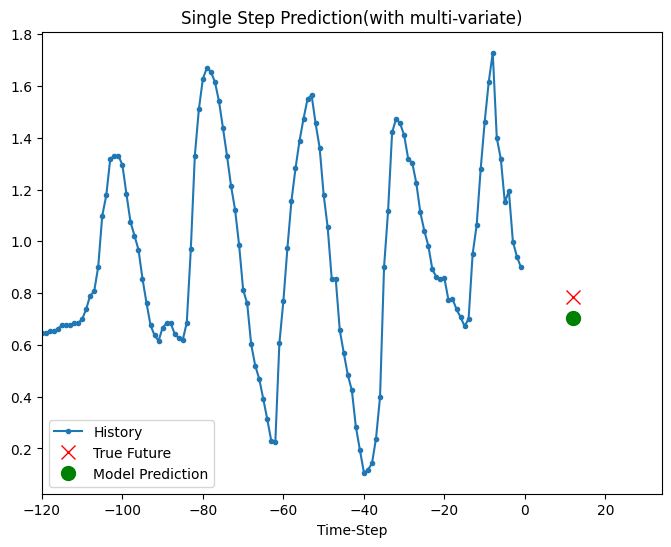

8/8 [==============================] - 0s 15ms/step


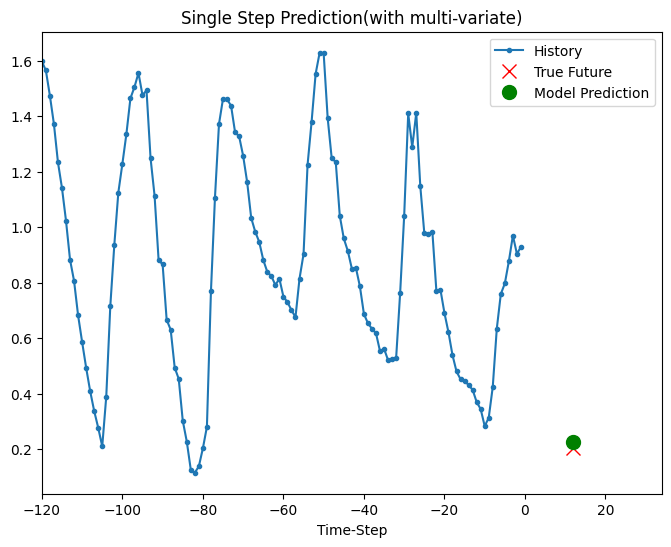

In [50]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    multi_single_model.predict(x)[0]], 12,
                   'Single Step Prediction(with multi-variate)')
  plot.show()

## 훨씬 정확하게 예측하는 것 처럼 보이네요!